# London Passenger Mode Choice

In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

#import packages
import pandas as pd
from pycmtensor.dataset import Dataset
from pycmtensor.expressions import Beta, RandomDraws
from pycmtensor.models import MNL

lpmc = pd.read_csv("../data/lpmc.dat", sep="\t")
lpmc = lpmc[lpmc["travel_year"]==2015]
ds = Dataset(df=lpmc, choice="travel_mode")
ds.split(0.8)

# Beta parameters
asc_walk = Beta("asc_walk", 0.0, None, None, 1)
asc_cycle = Beta("asc_cycle", 0.0, None, None, 0)
asc_pt = Beta("asc_pt", -1.379, None, None, 0)
asc_drive = Beta("asc_drive", -2.956, None, None, 0)
b_cost = Beta("b_cost", -0.141, None, None, 0)
b_time = Beta("b_time", -4.971, None, None, 0)
s_time = Beta("s_time", 0.5, None, None, 0)
b_purpose = Beta("b_purpose", 0.291, None, None, 0)
b_licence = Beta("b_licence", 1.464, None, None, 0)
b_car_own = Beta("b_car_own", 0.0, None, None, 0)

rnd_time = RandomDraws('rnd_time', 'lognormal', 100)

U_walk = asc_walk + b_time * ds["dur_walking"] # + rnd_time(s_time) * db["dur_walking"]
U_cycle = asc_cycle + b_time * ds["dur_cycling"] 
U_pt = asc_pt + b_time * (ds["dur_pt_rail"] + ds["dur_pt_bus"] + ds["dur_pt_int"]) + b_cost * ds["cost_transit"]
U_drive = asc_drive + b_time * ds["dur_driving"] + b_licence * ds["driving_license"] + b_cost * (ds["cost_driving_fuel"] + ds["cost_driving_ccharge"])  + b_purpose * ds["purpose"]

U = [U_walk, U_cycle, U_pt, U_drive]
mymodel = MNL(ds, locals(), U)

11:03:08 [INFO] seed: 100 n_train_samples:3986 n_valid_samples:997
11:03:09 [WARNING] s_time not in any utility functions
11:03:09 [WARNING] b_car_own not in any utility functions
11:03:09 [INFO] choice: travel_mode
11:03:09 [INFO] inputs in MNL: [purpose, driving_license, dur_walking, dur_cycling, dur_pt_rail, dur_pt_bus, dur_pt_int, dur_driving, cost_transit, cost_driving_fuel, cost_driving_ccharge]
11:03:10 [INFO] Build time = 00:00:01


## Estimate the models

In [2]:
from pycmtensor import train
from pycmtensor.optimizers import SGD, Adam, AdaGrad, SQNBFGS, RMSProp
from pycmtensor.scheduler import StepLR, ConstantLR

mymodel.reset_values()
train(mymodel, ds, optimizer=Adam, batch_size=0, base_learning_rate=0.1, convergence_threshold=0.001, max_epochs=2000, lr_scheduler=ConstantLR, lr_stepLR_drop_every=20, lr_stepLR_factor=0.99, BFGS_warmup=30)

11:03:14 [INFO] Start (n=3986, epoch=0, NLL=-5525.77, error=81.85%)
11:03:14 [INFO] Train 0/2K (epoch=0, LL=-5323.30, error=63.59%, gnorm=2.646e-01)
11:03:15 [INFO] Train 200/2K (epoch=200, LL=-3414.93, error=35.31%, gnorm=2.211e-03)
11:03:15 [INFO] Train 229/2K (epoch=229, LL=-3414.87, error=35.31%, gnorm=9.885e-04)
11:03:15 [INFO] Model converged (t=1.563)
11:03:15 [INFO] Best results obtained at epoch 229: LL=-3414.87, error=35.31%, gnorm=9.88461e-04


## Display results

In [3]:
pd.options.display.width = 99
print(mymodel.results.beta_statistics())
print(mymodel.results.model_statistics())
print(mymodel.results.benchmark())

           value std err  t-test p-value rob. std err rob. t-test rob. p-value
asc_cycle -3.949   0.082 -48.386     0.0        0.081     -48.689          0.0
asc_drive -2.954   0.092  -32.04     0.0        0.094     -31.383          0.0
asc_pt    -1.379   0.047 -29.619     0.0        0.049     -28.059          0.0
asc_walk     0.0       -       -       -            -           -            -
b_cost    -0.141   0.013 -10.941     0.0        0.012      -11.47          0.0
b_licence  1.463   0.081  18.152     0.0        0.086      17.088          0.0
b_purpose  0.291   0.032   9.138     0.0        0.032       8.965          0.0
b_time    -4.975   0.182 -27.336     0.0        0.195       -25.5          0.0
                                                 value
Number of training samples used                   3986
Number of validation samples used                  997
Number of estimated parameters in the model          8
Null log likelihood                           -5525.77
Init. log like

## Correlation matrix

In [4]:
print(mymodel.results.model_correlation_matrix())
print(mymodel.results.model_robust_correlation_matrix())

           asc_walk  asc_cycle  asc_pt  asc_drive  b_cost  b_time  b_purpose  b_licence
asc_walk      1.000     -0.278   0.133     -0.554   0.049  -0.644      0.433      0.307
asc_cycle    -0.278      1.000  -0.350     -0.504   0.128   0.035      0.255      0.133
asc_pt        0.133     -0.350   1.000     -0.293  -0.186   0.246      0.457      0.265
asc_drive    -0.554     -0.504  -0.293      1.000  -0.055   0.317     -0.773     -0.476
b_cost        0.049      0.128  -0.186     -0.055   1.000  -0.018     -0.025     -0.056
b_time       -0.644      0.035   0.246      0.317  -0.018   1.000     -0.090     -0.143
b_purpose     0.433      0.255   0.457     -0.773  -0.025  -0.090      1.000      0.026
b_licence     0.307      0.133   0.265     -0.476  -0.056  -0.143      0.026      1.000
           asc_walk  asc_cycle  asc_pt  asc_drive  b_cost  b_time  b_purpose  b_licence
asc_walk      1.000     -0.290   0.113     -0.565  -0.000  -0.697      0.428      0.326
asc_cycle    -0.290      1.000  

## Predictions

In [5]:
prob = mymodel.predict(ds)
print(pd.DataFrame(prob))

                0         1         2         3  pred_travel_mode  true_travel_mode
0    1.816248e-02  0.026326  0.114566  0.840946                 3                 3
1    3.065364e-02  0.015545  0.128382  0.825420                 3                 2
2    6.246189e-01  0.019188  0.264846  0.091347                 0                 2
3    3.817132e-08  0.002589  0.073193  0.924218                 3                 3
4    5.005149e-05  0.025316  0.827526  0.147108                 2                 3
..            ...       ...       ...       ...               ...               ...
992  3.488616e-01  0.013858  0.159682  0.477598                 3                 0
993  7.497424e-03  0.028629  0.107076  0.856797                 3                 3
994  2.811260e-01  0.014601  0.175604  0.528669                 3                 3
995  3.967949e-05  0.005089  0.011836  0.983035                 3                 3
996  1.733436e-02  0.030785  0.182990  0.768891                 3           

## Elasticities

In [6]:
elas = mymodel.elasticities(ds=ds, wrt_choice=3)
print(pd.DataFrame(elas).round(3))

      cost_driving_ccharge  cost_driving_fuel  cost_transit  driving_license  dur_cycling  \
0                     -0.0             -0.033         0.063            0.228        0.022   
1                     -0.0             -0.074         0.159            0.717        0.022   
2                     -0.0             -0.110         0.189            0.000        0.030   
3                     -0.0             -0.032         0.000            0.793        0.016   
4                     -0.0             -0.089         0.113            0.000        0.031   
...                    ...                ...           ...              ...          ...   
3981                  -0.0             -0.023         0.000            0.000        0.008   
3982                  -0.0             -0.131         0.000            0.798        0.038   
3983                  -0.0             -0.018         0.050            0.565        0.016   
3984                  -0.0             -0.012         0.040           

In [7]:
import numpy as np 
np.mean(pd.DataFrame(elas), axis=0)

cost_driving_ccharge   -0.158740
cost_driving_fuel      -0.063035
cost_transit            0.088113
driving_license         0.407457
dur_cycling             0.042464
dur_driving            -0.795293
dur_pt_bus              0.225916
dur_pt_int              0.079587
dur_pt_rail             0.245821
dur_walking             0.333449
purpose                 0.440599
dtype: float64

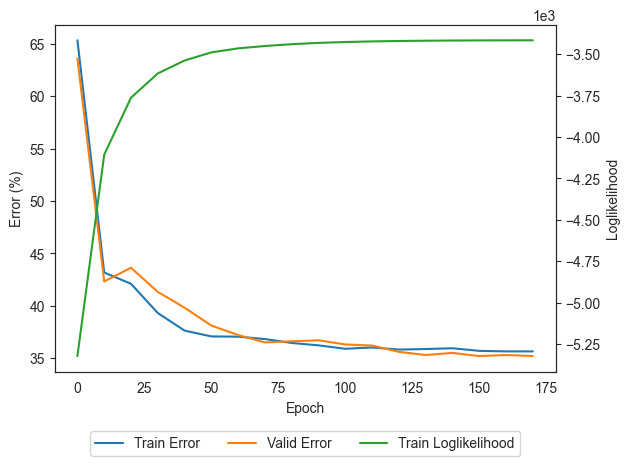

In [8]:
table = mymodel.results.show_training_plot(offset=0, cutoff=180, sample_intervals=10)